In [1]:
import gzip, shutil
import os 
import data_utils as du 
import tensorflow as tf 
from tensorflow import keras 
import numpy as np 
from six.moves import cPickle as pickle
import numpy as np
import os
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt 
import platform
import data_utils as du 
from cnn_model import *
from solver import Solver
import qunatize_resnet20 as q_res
import quantize_layers as ql
import tensorflow_hub as hub 
import quantize_util as qu 
import quantize_complier as qc 


%load_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext autoreload
plt.rcParams['figure.figsize'] = (15.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Data_folder = 'CIFAR10_Data'
Data_fn = 'cifar-10-python'
X_train, y_train, X_val, y_val, X_test, y_test = du.get_CIFAR10_data(subtract_mean =True)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape, y_train.dtype)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,) int64
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [84]:
data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 1,
    'from_logits':True,
    'save_dir': 'resnet20_model'
}
model_path = 'resnet20_model/trained_15'
full_model = hub.KerasLayer(model_path,trainable=True)

qunatizer = ql.ModelQunatize() 
model_q = q_res.Resnet20(qunatizer)
qu.copy_weight(model_q,full_model)
q_layers = model_q.get_quantizable_layers()
for layer in q_layers:
    print(layer)

solver = Solver(model_q,data_set,train_options,save_model=False)

data_shuffler = qc.DataShuffler(X_train, y_train,sample_size=1024)


def train_fn(model,solver=solver):
    solver = Solver(model,data_set,train_options,
                    save_model=False,verbose=False,
                    plot_graph=False)
    return solver.train(iter=int(5000/32))

def test_fn(model,solver=solver,shuffle=False):
    solver = Solver(model,data_set,save_model=False,
                    verbose=False,plot_graph=False)
    #X_s,y_s = data_shuffler.sample(shuffle)
    #return solver.test_model(X_test[0:8*1024-1],y_test[0:8*1024-1])
    #return solver.test_model(X_test[0:1024*6-1],y_test[0:1024*6-1])
    #return solver.test_model(X_s,y_s)
    return solver.test_model(X_test,y_test)






In [85]:
q_complier = qc.QunatizeComplier(model_q,full_model,q_layers,train_fn,test_fn,verbose=True,target_compression=0.005,max_loss=0.05)
qunatizer.set_wlfl_list(q_complier.wl_agent.get_wl_list())
q_complier.quantize_model()

,6,0,0][4,5,0,0][7,8,0,0][8,8,0,0][4,5,0,0][3,5,0,0][3,5,0,0][3,5,0,0][4,7,0,0][3,4,0,0][8,8,8,6]]
reduce wl on layer 11 kernel,acc_loss: 0.009000003337860107, current accuracy:0.6901000142097473, compression rate: 0.127650496001431
<quantize_complier.WlflList object at 0x7f916c71c160>[[8,7,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][6,6,0,0][6,6,0,0][4,5,0,0][6,7,0,0][8,8,0,0][4,5,0,0][3,5,0,0][3,5,0,0][3,5,0,0][4,7,0,0][3,4,0,0][8,8,8,6]]
reduce wl on layer 8 kernel,acc_loss: 0.027200043201446533, current accuracy:0.6718999743461609, compression rate: 0.12657725473828565
<quantize_complier.WlflList object at 0x7f916c71c160>[[8,7,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][8,8,0,0][5,6,0,0][6,6,0,0][4,5,0,0][6,6,0,0][8,8,0,0][4,5,0,0][3,5,0,0][3,5,0,0][3,5,0,0][4,7,0,0][3,4,0,0][8,8,8,6]]
------Fine tune the model------
Epoch: 0/1
  156/1531 |==***********************|  - train_acc: 0.9267 - train_loss: 0.2047 - val_acc: NA    - val_loss: NA   
r

(<qunatize_resnet20.Resnet20 at 0x7f943bc3e580>,
 <quantize_complier.WlflList at 0x7f916c71c160>)

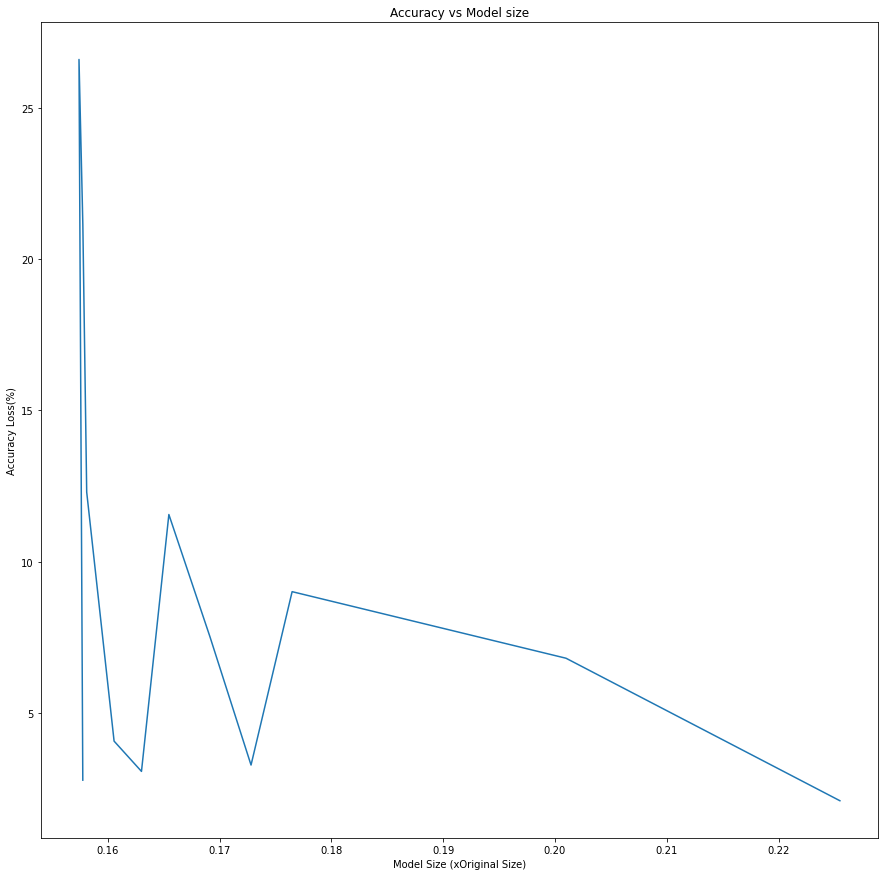

AttributeError: 'Quantize_Lenet5' object has no attribute 'model'

In [29]:
q_complier.wl_agent.plot_logger() 
model_save_path = 'complier_tmp/maxloss_005_deep_compressed_resnet20_model'
wlfl_save_path = 'complier_tmp/maxloss_005_deep_compressed_resnet20_wlfl.txt'
model_q.model.save_weights(model_save_path)
qu.copy_weight(full_model,model_q)
tf.saved_model.save(full_model,model_save_path)
q_complier.wl_agent.get_wl_list().save(wlfl_save_path)


## Result of (max compress 0.005, max acc loss 0.015)

In [17]:
data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 1,
    'from_logits':True,
    'save_dir': 'resnet20_model'
}
model_path = 'resnet20_model/trained_15'
full_model = hub.KerasLayer(model_path,trainable=True)
solver = Solver(full_model,data_set,train_options,save_model=False)
full_model_acc = solver.test_model(X_test,y_test)[1]
print('Model test accuracy before quantization: {}'.format(full_model_acc))


q_complier = qc.QunatizeComplier(model_q,full_model,q_layers,train_fn,test_fn,verbose=True,target_compression=0.005,max_loss=0.04)
qunatize_model_save_path = 'complier_tmp/max_loss_0005_deep_compressed_resnet20_model'
qunatize_WL_file = 'complier_tmp/max_loss_0005_deep_compressed_resnet20_wlfl.txt'
model_q.model.load_weights(model_save_path)
q_complier.wl_agent.get_wl_list().load(qunatize_WL_file)
model_q.set_quantize()
print('\nApply the WL and FL of the quantized model \n{}'.format(q_complier.wl_agent.get_wl_list()))
print('\nCompress rate (x origin size): {}'.format(q_complier.wl_agent.get_compression_rate()))
q_complier.fl_agent.apply_wlfl_to_layers(model_q.get_quantizable_layers(),q_complier.wl_agent.get_wl_list())
quantize_model_acc = q_complier.fl_agent.model_accuracy()
print('\nAccuracy after quantize: {} '.format(quantize_model_acc))

print('\n Accuracy loss {}'.format(full_model_acc-quantize_model_acc))

Loss: 0.9363389611244202,Test Accuracy: 69.91000366210938
Model test accuracy before quantization: 0.6991000175476074

Apply the WL and FL of the quantized model 
<quantize_complier.WlflList object at 0x7f93c85ae460>[[5,5,0,0][5,5,0,0][5,5,0,0][4,4,0,0][3,4,0,0][3,4,0,0][4,4,0,0][5,5,0,0][5,5,0,0][5,5,0,0][3,4,0,0][4,5,0,0][5,5,0,0][5,5,0,0][5,5,0,0][5,5,0,0][5,5,0,0][6,6,0,0][5,5,0,0][5,5,0,0]]

Compress rate (x origin size): (0.15570755666192154, 1337072)

Accuracy after quantize: 0.6851999759674072 

 Accuracy loss 0.013900041580200195


## Result of (max compress 0.005  max acc loss:0.03)


In [28]:
q_complier = qc.QunatizeComplier(model_q,full_model,q_layers,train_fn,test_fn,verbose=True,target_compression=0.005,max_loss=0.03)
qunatize_model_save_path = 'complier_tmp/maxloss_003_deep_compressed_resnet20_model'
qunatize_WL_file = 'complier_tmp/maxloss_003_deep_compressed_resnet20_wlfl.txt'
model_q.model.load_weights(model_save_path)
q_complier.wl_agent.get_wl_list().load(qunatize_WL_file)
model_q.set_quantize()
print('\nApply the WL and FL of the quantized model \n{}'.format(q_complier.wl_agent.get_wl_list()))
print('\nCompress rate (x origin size): {}'.format(q_complier.wl_agent.get_compression_rate()))
q_complier.fl_agent.apply_wlfl_to_layers(model_q.get_quantizable_layers(),q_complier.wl_agent.get_wl_list())
quantize_model_acc = q_complier.fl_agent.model_accuracy()
print('\nAccuracy after quantize: {} '.format(quantize_model_acc))

print('\n Accuracy loss {}'.format(full_model_acc-quantize_model_acc))


Apply the WL and FL of the quantized model 
<quantize_complier.WlflList object at 0x7f948486d760>[[5,5,0,0][4,4,0,0][4,4,0,0][3,4,0,0][3,4,0,0][3,4,0,0][2,3,0,0][4,4,0,0][4,4,0,0][5,5,0,0][3,4,0,0][4,5,0,0][5,5,0,0][5,5,0,0][4,4,0,0][4,4,0,0][3,4,0,0][4,4,0,0][3,4,0,0][4,3,0,0]]

Compress rate (x origin size): (0.11833789212434692, 1016176)

Accuracy after quantize: 0.6704000234603882 

 Accuracy loss 0.02869999408721924


## Result of 

In [88]:
q_complier = qc.QunatizeComplier(model_q,full_model,q_layers,train_fn,test_fn,verbose=True,target_compression=0.005,max_loss=0.03)

qunatize_model_save_path = 'complier_tmp/maxloss_002_deep_compressed_resnet20_model'
qunatize_WL_file = 'complier_tmp/maxloss_002_deep_compressed_resnet20_wlfl.txt'
model_q.model.load_weights(qunatize_model_save_path)
#qu.copy_weight(model_q,full_model)
q_complier.wl_agent.get_wl_list().load(qunatize_WL_file)
model_q.set_quantize()
print('\nApply the WL and FL of the quantized model \n{}'.format(q_complier.wl_agent.get_wl_list()))
print('\nCompress rate (x origin size): {}'.format(q_complier.wl_agent.get_compression_rate()))
q_complier.fl_agent.apply_wlfl_to_layers(model_q.get_quantizable_layers(),q_complier.wl_agent.get_wl_list())
quantize_model_acc = q_complier.fl_agent.model_accuracy()
print('\nAccuracy after quantize: {} '.format(quantize_model_acc))

print('\n Accuracy loss {}'.format(full_model_acc-quantize_model_acc))


Apply the WL and FL of the quantized model 
<quantize_complier.WlflList object at 0x7f93c8104340>[[7,7,0,0][6,7,0,0][8,8,0,0][8,8,0,0][8,8,0,0][7,8,0,0][8,8,0,0][5,8,0,0][4,6,0,0][3,6,0,0][3,5,0,0][4,6,0,0][4,5,0,0][4,5,0,0][3,5,0,0][3,5,0,0][3,5,0,0][1,7,0,0][1,4,0,0][8,8,8,6]]

Compress rate (x origin size): (0.09084167455449307, 780064)

Accuracy after quantize: 0.6365000009536743 

 Accuracy loss 0.0626000165939331


Text(0.5, 1.0, 'Accuracy vs Model Compress')

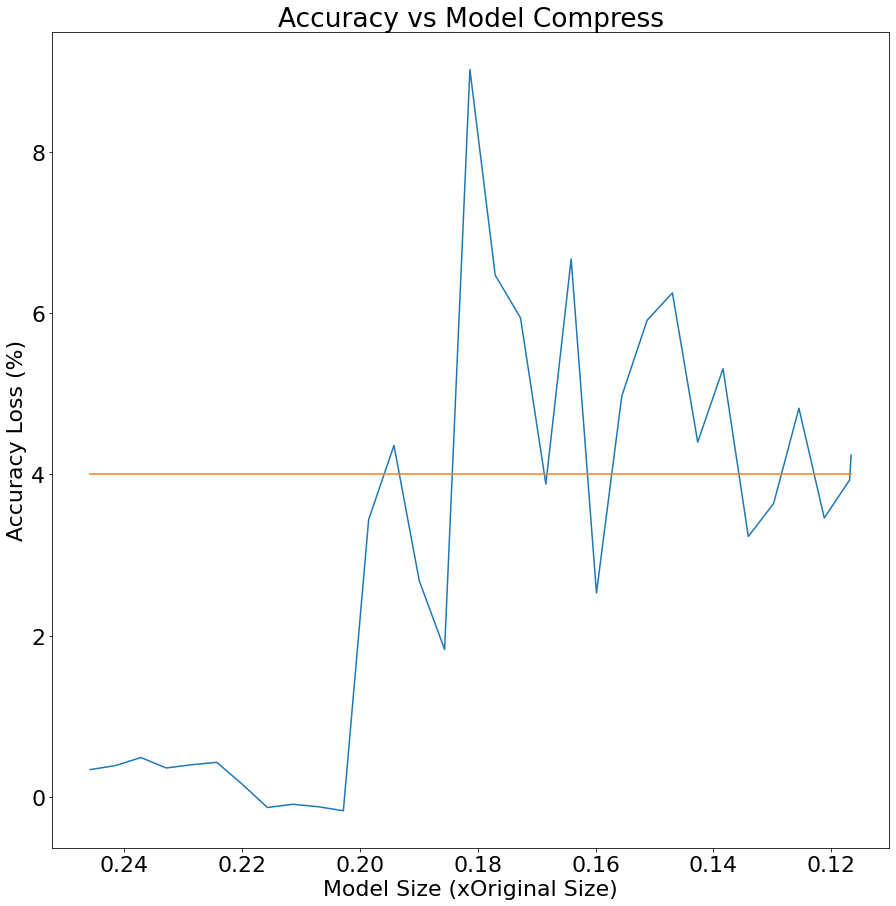

In [141]:
import matplotlib.pyplot as plt 
plt.rcParams.update({'font.size': 22})
acc_loss = q_complier.wl_agent.get_logger().get_acc_loss()
compress_rate = q_complier.wl_agent.get_logger().get_compress_rate() 
compress_rate.reverse()
plt.plot(np.array(compress_rate),100*np.array(acc_loss))
plt.plot(compress_rate, [4]*len(compress_rate))
plt.gca().invert_xaxis()
plt.xlabel('Model Size (xOriginal Size)')
plt.ylabel('Accuracy Loss (%)')
plt.title('Accuracy vs Model Compress')

# Test Complier on Lenet5 

## Train Lenet5 


Epoch: 0/30
 1532/1531 |=========================|  - train_acc: 0.3693 - train_loss: 1.7133 - val_acc: 0.4550 - val_loss: 1.5197
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
INFO:tensorflow:Assets written to: lenet5_model/trained_0/assets
Epoch: 1/30
 1532/1531 |=========================|  - train_acc: 0.4988 - train_loss: 1.4008 - val_acc: 0.5340 - val_loss: 1.3191
Epoch: 2/30
 1532/1531 |=========================|  - train_acc: 0.5447 - t

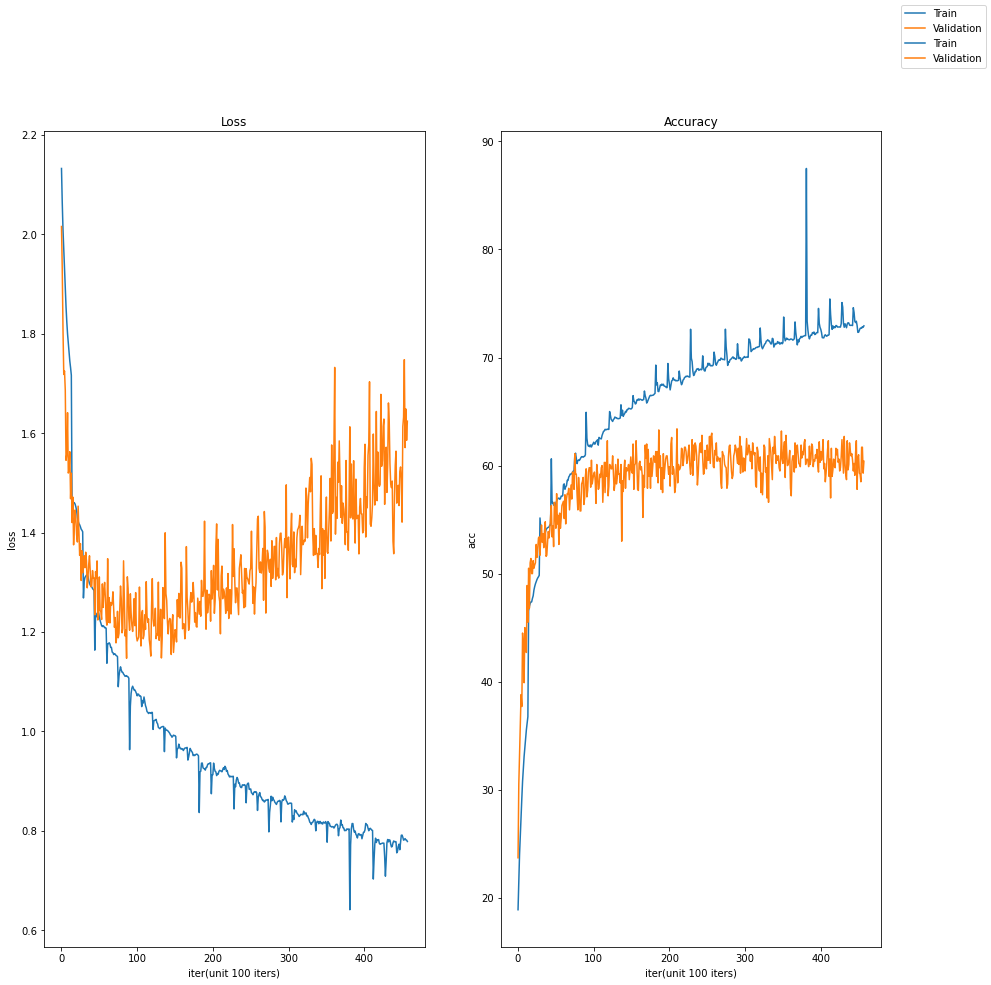

(<tf.Tensor: shape=(), dtype=float32, numpy=0.7761824>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.73006123>,
 <bound method Metric.__new__.<locals>.result_fn of <tensorflow.python.keras.metrics.Mean object at 0x7fdfc821cc40>>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.604>)

In [4]:
from quantize_Lenet import Quantize_Lenet5

data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 30,
    'from_logits':True,
    'save_dir': 'lenet5_model'
}
lenet_quantizer = ql.ModelQunatize() 
lenet5_q = Quantize_Lenet5(out_channel=10,quantizer=lenet_quantizer)
lenet5_q.set_full_precision() 
solver = Solver(lenet5_q,data_set,train_options,save_model=True)
solver.train() 


In [22]:
print('Test accuracy of LeNet5')

solver.test_model(X_test,y_test)
#full_lenet5 = hub.KerasLayer(lenet_model_path)


Test accuracy of LeNet5
Loss: 2.3025851249694824,Test Accuracy: 9.739999771118164


(<tf.Tensor: shape=(), dtype=float32, numpy=2.3025851>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0974>)

## Quantize the Lenet5 

In [30]:
from quantize_Lenet import Quantize_Lenet5
data_set = {
    'train_data': X_train,
    'train_label': y_train,
    'val_data':X_val,
    'val_label':y_val,
}
train_options = {
    'optimizer': 'adam',
    'lr': 0.001,
    'epoch_num': 1,
    'from_logits':True,
    'save_dir': 'lenet5_model'
}
lenet_quantizer = ql.ModelQunatize()
lenet_model_path = 'lenet5_model/trained_25'
full_model = hub.KerasLayer(lenet_model_path,trainable=True)

qunatizer = ql.ModelQunatize() 
model_q = Quantize_Lenet5(out_channel=10,quantizer=lenet_quantizer)
qu.copy_weight(model_q,full_model)
q_layers = model_q.get_quantizable_layers()
for layer in q_layers:
    print(layer)

solver = Solver(model_q,data_set,train_options,save_model=False)

data_shuffler = qc.DataShuffler(X_train, y_train,sample_size=1024)


def train_fn(model,solver=solver):
    solver = Solver(model,data_set,train_options,
                    save_model=False,verbose=False,
                    plot_graph=False)
    return solver.train(iter=int(20000/32))

def test_fn(model,solver=solver,shuffle=False):
    solver = Solver(model,data_set,save_model=False,
                    verbose=False,plot_graph=False)
    return solver.test_model(X_test,y_test)

In [32]:
q_complier = qc.QunatizeComplier(model_q,full_model,q_layers,train_fn,test_fn,verbose=True,target_compression=0.005,max_loss=0.05)
#qunatizer.set_wlfl_list(q_complier.wl_agent.get_wl_list())
q_complier.quantize_model()

Full percision model accuracy: 0.6031000018119812
************Coarse search begin************
Coarse seach done, compression rate:(0.25, 979280),quantize model accuracy: 0.6037999987602234

************Fine search begin************

reduce wl on layer 2 kernel,acc_loss: 0.021000027656555176, current accuracy:0.582099974155426, compression rate: 0.22549219834980802
<quantize_complier.WlflList object at 0x7f675c1dbbe0>[[8,8,8,4][8,8,8,5][7,8,8,5][8,8,8,5][8,7,8,5]]
------Fine tune the model------
Epoch: 0/1
  625/1531 |==========***************|  - train_acc: 0.7247 - train_loss: 0.8010 - val_acc: 0.6060 - val_loss: 1.4840
reduce wl on layer 2 kernel,acc_loss: 0.08009999990463257, current accuracy:0.5230000019073486, compression rate: 0.20098439669961604
<quantize_complier.WlflList object at 0x7f675c1dbbe0>[[8,8,8,4][8,8,8,5][6,8,8,5][8,8,8,5][8,7,8,5]]
------Fine tune the model------
Epoch: 0/1
  625/1531 |==========***************|  - train_acc: 0.7188 - train_loss: 0.8103 - val_acc: 0

(<quantize_Lenet.Quantize_Lenet5 at 0x7f67418bcaf0>,
 <quantize_complier.WlflList at 0x7f675c1dbbe0>)

In [33]:
model_save_path = 'Lenet5_compiler_output/maxloss_005_deep_compressed_model'
wlfl_save_path = 'Lenet5_compiler_output/maxloss_005_deep_compressed_wlfl.txt'
model_q.save_weights(model_save_path)
#qu.copy_weight(full_model,model_q)
#tf.saved_model.save(full_model,model_save_path)
q_complier.wl_agent.get_wl_list().save(wlfl_save_path)